L'obiettivo di questa esercitazione è quello di arrivare ad implementare un sistema completo di classificazione dei sopravvissuti al disastro del Titanic. Per farlo, partiremo dall'omonimo dataset, faremo un'analisi completa dello stesso, e cercheremo di raggiungere il miglior risultato possibile in termini di accuracy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

## Parte 1: estrazione dei dati

Finora, abbiamo sempre usato la funzione `read_csv` di Pandas per la lettura di un dataset. Scikit Learn, però, offre la funzione [`fetch_openml`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html), che permette di estrarre un dataframe da [OpenML](https://www.openml.org/), nota repository online dalla quale è possibile reperire numerosi dataset.

Proviamo quindi ad estrarre i dati usando proprio questa funzione.

> **Suggerimento**: la funzione `fetch_openml` restituisce un oggetto. Esploriamolo, assieme alla documentazione, per estrarre il dataframe.

In [24]:
data = fetch_openml("titanic", version=1, as_frame=True)
df = data.frame

## Parte 2: Exploratory data analysis

Come abbiamo visto, è sempre opportuno "esplorare" i dati a nostra disposizione.

### Parte 2.1: Tipologia di feature e preprocessing

Per prima cosa, quindi, osserviamoli, guardando i primi cinque campioni, e valutiamo il tipo delle feature che stiamo utilizzando.

In [25]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [26]:
print(df.dtypes)

pclass        float64
survived     category
name           object
sex          category
age           float64
sibsp         float64
parch         float64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object


Notiamo subito che ci sono dei `NaN` relativi a diverse feature.

Abbiamo due possibilità: la prima è quella di eliminare i campioni che presentano dati mancanti, la seconda è quella di eliminare le feature che presentano tali valori. Scriviamo la funzione `drop_nan` che elimini una feature qualora il numero di dati mancanti sia superiore al 25% del totale e che, una volta terminata questa operazione, provveda ad eliminare i campioni che presentano una o più feature con dati mancanti.

In [27]:
def drop_nan(df):
    threshold = round(len(df) / 4)
    df.dropna(axis=1, inplace=True, thresh=threshold)
    df.dropna(axis=0, inplace=True)

Prima di applicare la funzione `drop_nan`, però, eliminiamo le feature che non reputiamo significative ai fini della nostra analisi. In particolare, potremmo eliminare feature come il nome o il numero di ticket.

Notiamo inoltre che `boat` ha diversi valori a `None`, indicativi del fatto che il passeggero non è stato imbarcato su alcuna scialuppa di salvataggio. Assegnamo uno zero a tutti i dati che assumono valore `None` mediante la funzione [`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html).

> **Suggerimento**: la funzione `apply` prevede l'utilizzo delle *lambda function*. Per brevità, queste funzioni hanno una sintassi di questo tipo:
> ```python
> lambda x: f(x)
> ```
> Ciò significa che sarà applicata `f(x)` ad ogni valore di `x`. Così, ad esempio:
> ```python
> df = pd.DataFrame([1, 2, 3])
> df = df.apply(lambda x: x**2)
> # Risultato: pd.DataFrame([1, 4, 9])
> ```


In [28]:
df.drop(['name', 'ticket'], axis=1, inplace=True)
df['boat'] = df['boat'].apply(lambda x: '0' if x is None else x)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,home.dest
0,1.0,1,female,29.0000,0.0,0.0,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1,male,0.9167,1.0,2.0,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0,female,2.0000,1.0,2.0,151.5500,C22 C26,S,0,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0,male,30.0000,1.0,2.0,151.5500,C22 C26,S,0,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0,female,25.0000,1.0,2.0,151.5500,C22 C26,S,0,NaN,"Montreal, PQ / Chesterville, ON"


Applichiamo adesso la funzione `drop_nan`.

In [29]:
drop_nan(df)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,boat,home.dest
0,1.0,1,female,29.0000,0.0,0.0,211.3375,S,2,"St Louis, MO"
1,1.0,1,male,0.9167,1.0,2.0,151.5500,S,11,"Montreal, PQ / Chesterville, ON"
2,1.0,0,female,2.0000,1.0,2.0,151.5500,S,0,"Montreal, PQ / Chesterville, ON"
3,1.0,0,male,30.0000,1.0,2.0,151.5500,S,0,"Montreal, PQ / Chesterville, ON"
4,1.0,0,female,25.0000,1.0,2.0,151.5500,S,0,"Montreal, PQ / Chesterville, ON"


Siamo rimasti con dieci feature, rispetto alle 14 iniziali. Notiamo anche che abbiamo alcune feature che possiamo contrassegnare come *categorical*, ovvero:

* `sex`
* `embarked`
* `home.dest`

### Parte 2.2: Esplorazione dei dati

Usiamo adesso congiuntamente gli strumenti degli *istogrammi* e degli *scatter plot* per esplorare visivamente le singole feature. Partiamo dall'età.

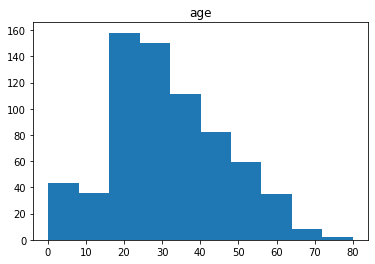

In [39]:
df.hist(
    column='age',
    grid=False
)
plt.show()

Come possiamo vedere, l'età ricorda una distribuzione di Rayleigh. Ci attendiamo lo stesso per un'altra dimensione che possiamo esplorare, ovvero quella delle tariffe pagate dai singoli passeggeri.

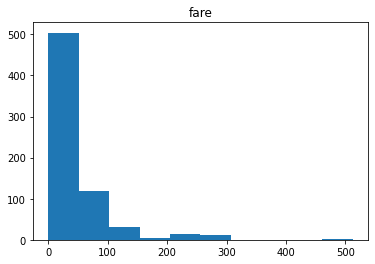

In [41]:
df.hist(
    column='fare',
    grid=False
)
plt.show()

Vediamo come si dispongono le due feature usando uno scatter plot.

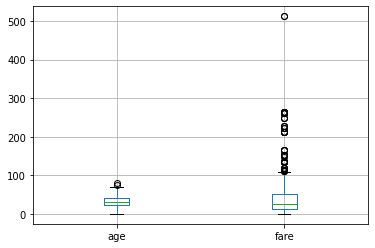

In [65]:
df.boxplot(['age', 'fare'])
plt.show()

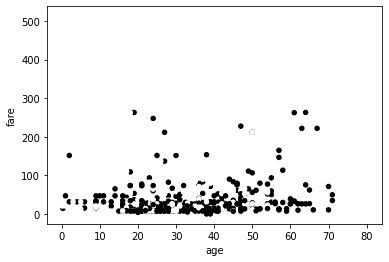

In [73]:
df.plot.scatter(x='age', y='fare', c='survived', cmap='inferno')
plt.show()

Notiamo come la variabilità dell'età è sufficiente, mentre quella del ticket è bassa. Proveremo in tal senso ad usare una tecnica di feature selection basata su `VarianceThreshold`.

In ultimo, valutiamo la matrice di correlazione. Usiamo l'indice di correlazione di Kendall, che risulta essere maggiormente robusto rispetto a quello di Pearson ed a quello di Spearman. Per approfondire, ecco un [eccellente punto di partenza](https://datascience.stackexchange.com/a/64261) su Stack Exchange.

In [74]:
df.corr(method='kendall')

,pclass,age,sibsp,parch,fare
pclass,1.000000,-0.337074,-0.035663,0.031975,-0.609570
age,-0.337074,1.000000,-0.071200,-0.166610,0.148868
sibsp,-0.035663,-0.071200,1.000000,0.347454,0.338960
parch,0.031975,-0.166610,0.347454,1.000000,0.292990
fare,-0.609570,0.148868,0.338960,0.292990,1.000000


E' facile vedere come i risultati ci conducano alla conclusione che non vi sono feature fortemente correlate od anticorrelate; la correlazione maggiore che è possibile riscontrare è infatti tra classe del passeggero e tariffa (ed è negativa, come prevedibile: ciò significa che passeggeri con classe numerica più alta, ovvero terza, hanno pagato meno rispetto a passeggeri con classe numerica più bassa, ovvero seconda e prima).

## Parte 2: feature selection ed addestramento

Procediamo adesso alla feature selection ed all'addestramento. Useremo due algoritmi: il primo è un classificatore basato su alberi decisionali, mentre il secondo è un classificatore basato su MLP, ovvero su un'architettura di rete che è alla base delle reti neurali.

In [8]:
df.dropna(axis=0, inplace=True)
labels = df['survived']
df.drop('survived', axis=1, inplace=True)

In [21]:
ct = ColumnTransformer(
    [('sex_tr', OneHotEncoder(handle_unknown='ignore'), ['sex']),
     ('embarked_tr', OneHotEncoder(handle_unknown='ignore'), ['embarked']),
     ('boat_tr', OneHotEncoder(handle_unknown='ignore'), ['boat'])], remainder='passthrough')

In [10]:
X, y = ct.fit_transform(df), labels

In [11]:
dt = DecisionTreeClassifier()
mlp = MLPClassifier(max_iter=1000)

In [12]:
scoring=['accuracy']
dt_scores = cross_validate(dt, X, y, cv=10, scoring=scoring)
mlp_scores = cross_validate(mlp, X, y, cv=10, scoring=scoring)

In [13]:
mlp_scores['test_accuracy']

array([0.96190476, 0.98095238, 0.99047619, 0.98076923, 0.95192308,
       0.97115385, 0.97115385, 0.96153846, 0.96153846, 0.95192308])

In [14]:
dt_scores['test_accuracy']

array([0.97142857, 0.98095238, 0.95238095, 0.96153846, 0.95192308,
       0.96153846, 0.92307692, 0.95192308, 0.94230769, 0.95192308])

In [15]:
dt.fit(X, y)

DecisionTreeClassifier()

In [16]:
mlp.fit(X, y)

MLPClassifier(max_iter=1000)

## Parte 4: Utilizzo di una pipeline

In [22]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('ct', ct),
    ('fs', VarianceThreshold()),
    ('clf', DecisionTreeClassifier()),
])

cross_validate(pipe, df, labels, cv=10)

{'fit_time': array([0.02409935, 0.01921844, 0.01503372, 0.01658511, 0.01601315,
        0.01597762, 0.01497436, 0.01499939, 0.0150001 , 0.01602507]),
 'score_time': array([0.01090026, 0.00911188, 0.00896788, 0.00908756, 0.00802398,
        0.00802159, 0.00802922, 0.00799942, 0.00700688, 0.00796485]),
 'test_score': array([0.96190476, 0.98095238, 0.95238095, 0.96153846, 0.94230769,
        0.96153846, 0.92307692, 0.94230769, 0.95192308, 0.95192308])}